In [2]:
from monk import Dataset, PredictorPipe, cfg_static_default, cfg_inference_default, Image
from monk.inference.wrappers import (
    Centermask2InstanceWrapper,
    DeeplabSemanticWrapper,
    Detectron2InstanceWrapper,
    Fastai2Classification,
    InstanceWrapper,
    SemanticWrapper,
    Wrapper,
    Yolov5InstanceWrapper,
)
import numpy as np
import torch

from monk.config.default import PipelineInferenceConfig, PipelineStaticConfig
from monk.inference.prediction import (
    PredictionBrandModel,
    PredictionImageType,
    PredictionInstance,
    PredictionSemantic,
    PredictionViewpoint,
)
from monk.utils.extend_boxes import preprocess_bbox



from monk.evaluation.evaluators.damage_detection import BBoxDamageDetection, DamageDetection
from monk.evaluation.evaluators.instance2sem import Instance2SemEvaluator
from monk.evaluation import EvaluatorRoutine

from monk import Masks
from monk import Mask
from monk import BBox

import joblib
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow_addons as tfa
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [4]:
import tensorflow as tf
import numpy as np

In [5]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
from augmenter import CustomAugment
from model import get_resnet_simclr

from losses import _dot_simililarity_dim1 as sim_func_dim1
from losses import _dot_simililarity_dim2 as sim_func_dim2

# DATASET

In [6]:
path ='/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea'
parts_ds= []
dam_ds =[]
for d in os.listdir(path):
    if 'parts' in d:
        parts_ds.append(d)
    else:
        dam_ds.append(d)
        
path_damaged = path+'/'+dam_ds[0]

path_non_damaged = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_train.json'
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"] 

#to_keep='all'

In [7]:
path_damaged

'/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_40004_damages.json'

In [6]:
gen = get_mixed_generator(path_damaged,path_non_damaged, batch_size=32, dim=(228,228), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  19%|#8        | 1311/6968 [00:01<00:04, 1310.54it/s]

Importing from COCO JSON:   4%|3         | 453/11876 [00:01<00:25, 452.39it/s]

(32, 228, 228, 3)


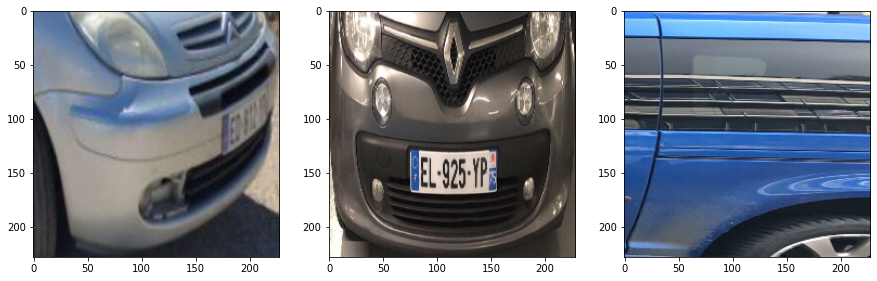

In [7]:
r = gen.__getitem__(np.random.randint(1,1000))
print(r.shape)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(r[0])
plt.subplot(1,3,2)
plt.imshow(r[1])
plt.subplot(1,3,3)
plt.imshow(r[2])

# AUGMENT

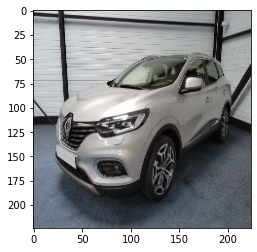

In [8]:
img = cv2.imread('/home/ubuntu/shared/data/auto_ici/images/133408_0067035172fc786488ff7c6317ed88c9.jpg')
img = cv2.resize(img,(224,224))/255
img = np.array(img,dtype=np.float32)
plt.imshow(img)

In [9]:
# Build the augmentation pipeline
data_augmentation = tf.keras.Sequential([tf.keras.layers.Lambda(CustomAugment())])


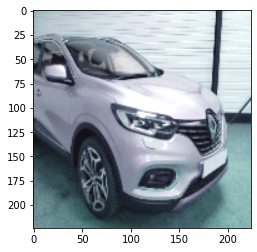

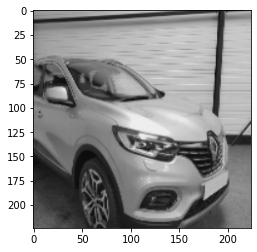

In [10]:
aug = data_augmentation(np.array([img,img]))
plt.imshow(aug[0])
plt.figure()
plt.imshow(aug[1])

# MODEL

In [11]:
BATCH_SIZE=32

In [12]:
model = get_resnet_simclr()

In [13]:
def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

negative_mask = get_negative_mask(BATCH_SIZE)


In [14]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [15]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            print("h")
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)
            print(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

In [16]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)

optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

In [ ]:
epoch_wise_loss, resnet_simclr  = train_simclr(model, gen, optimizer, criterion, temperature=0.1, epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

h
tf.Tensor(2.3412066, shape=(), dtype=float32)
h
tf.Tensor(1.4011126, shape=(), dtype=float32)
h
tf.Tensor(1.7061577, shape=(), dtype=float32)
h
tf.Tensor(1.792566, shape=(), dtype=float32)
h
tf.Tensor(1.4487765, shape=(), dtype=float32)
h
tf.Tensor(0.8433377, shape=(), dtype=float32)
h
tf.Tensor(0.73653567, shape=(), dtype=float32)
h
tf.Tensor(1.6661563, shape=(), dtype=float32)
h
tf.Tensor(1.3603644, shape=(), dtype=float32)
h
tf.Tensor(1.177774, shape=(), dtype=float32)
h


In [ ]:
len(gen)